In [1]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

In [2]:
import zipfile
import os

zip_path = "/content/garbage.zip"
extract_path = "/content/garbage_dataset"

# Extract the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Show what was extracted
print("Extracted folders:", os.listdir(extract_path))

Extracted folders: ['TrashType_Image_Dataset']


In [3]:
dataset_dir = "/content/garbage_dataset/TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [6]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [7]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


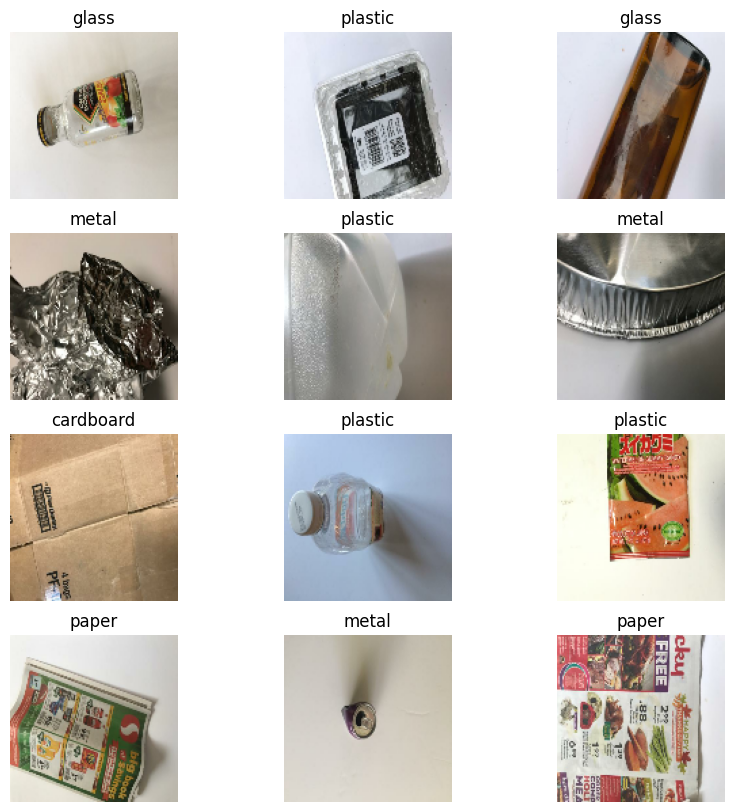

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [9]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [10]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [11]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


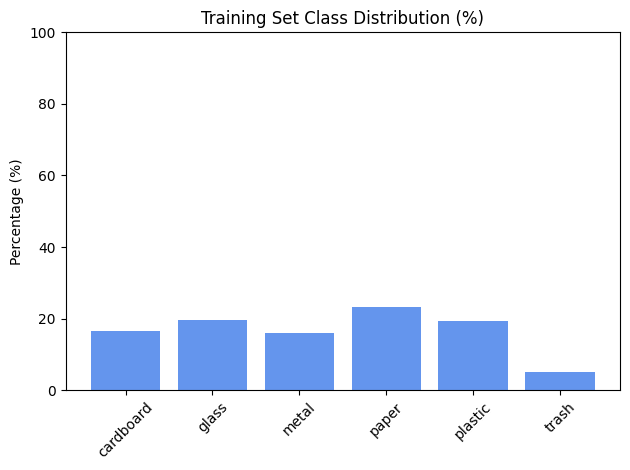

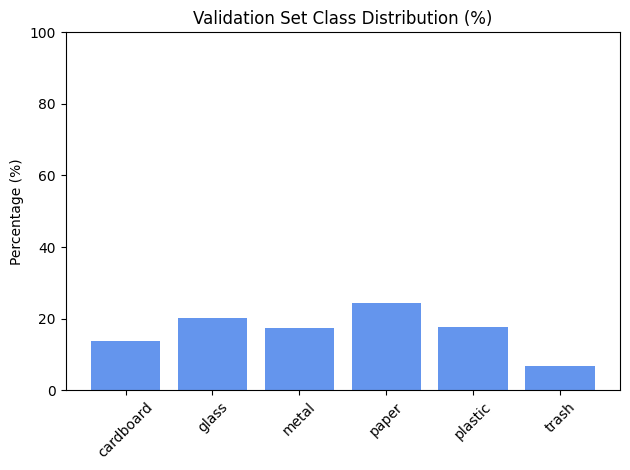

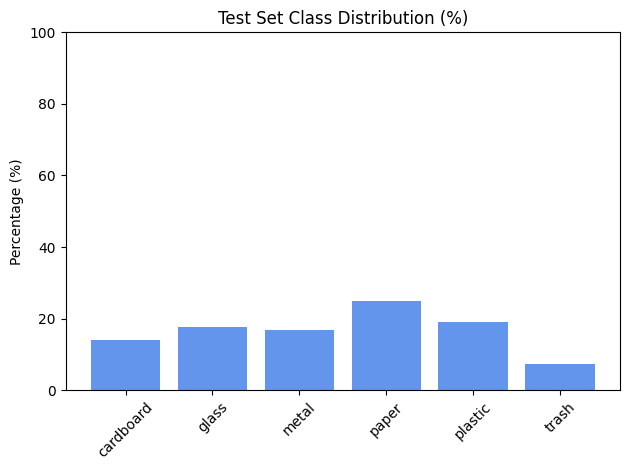

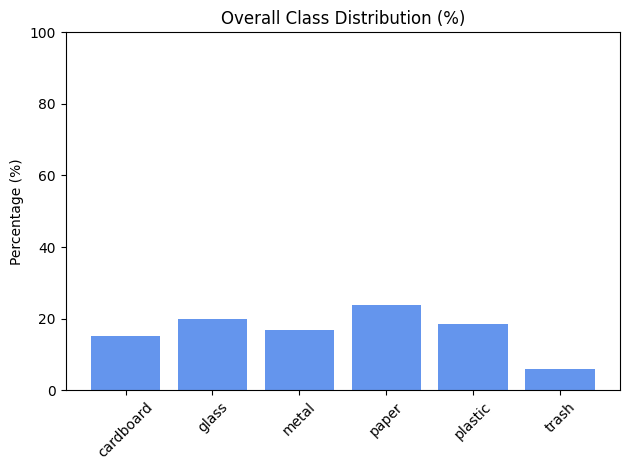

In [12]:
# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [13]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [14]:
# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}


In [15]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [16]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False

In [17]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])

In [18]:
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [20]:
# Set the number of epochs to train the model
epochs = 15  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 67s 231ms/step - accuracy: 0.2883 - loss: 1.6901 - val_accuracy: 0.5703 - val_loss: 1.2262
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.6506 - loss: 1.0933 - val_accuracy: 0.7683 - val_loss: 0.8544
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.7704 - loss: 0.7392 - val_accuracy: 0.8218 - val_loss: 0.6109
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.8332 - loss: 0.5236 - val_accuracy: 0.8436 - val_loss: 0.4933
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.8667 - loss: 0.3922 - val_accuracy: 0.8634 - val_loss: 0.4315
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.9076 - loss: 0.2919 - val_accuracy: 0.8554 - val_loss: 0.3920
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9325 - loss: 0.2321 - val_accuracy: 0.8752 - val_loss: 0.3628
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9397 - loss: 0.1935 - val_accuracy:

In [21]:
# 📝 Summary (optional but useful)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [22]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 124, 124,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 124, 124,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 31, 31,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 31, 31,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

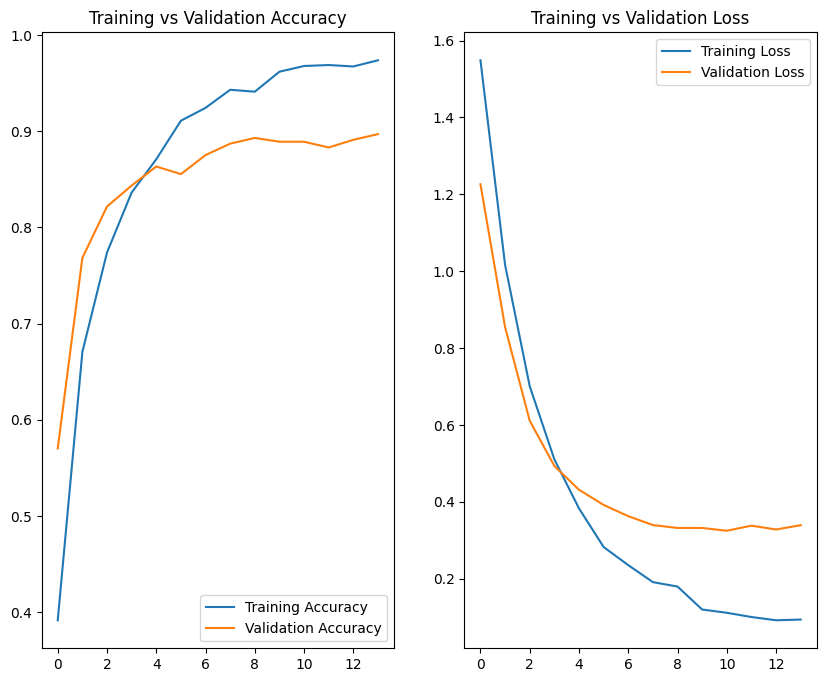

In [23]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()                                 # Display the plots

In [24]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9216 - loss: 0.2392
Test accuracy is0.9062, Test loss is 0.2980


In [25]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
[[29  0  0  1  0  0]
 [ 0 39  3  0  5  0]
 [ 1  0 47  0  1  1]
 [ 1  0  2 58  0  1]
 [ 0  0  0  0 40  5]
 [ 1  0  1  1  0 19]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       1.00      0.83      0.91        47
           2       0.89      0.94      0.91        50
           3       0.97      0.94      0.95        62
           4       0.87      0.89      0.88        45
           5       0.73      0.86      0.79        22

    accuracy                           0.91       256
   macro avg       0.89      0.90      0.90       256
weighted avg       0.91      0.91      0.91       256



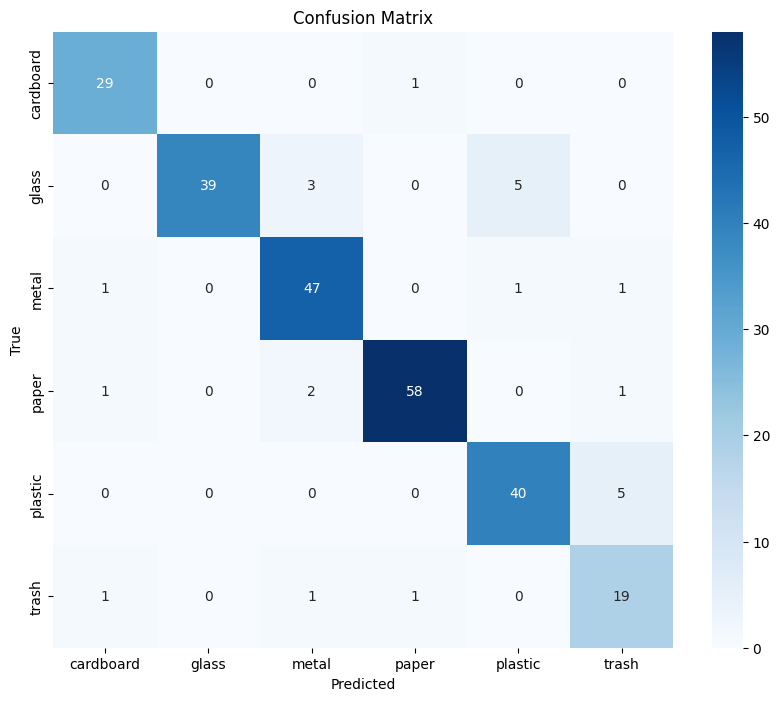

In [26]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


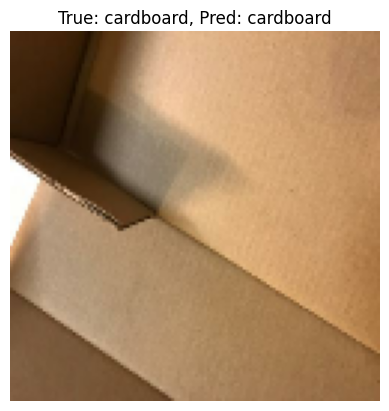

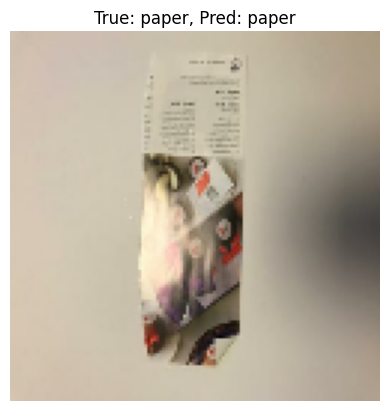

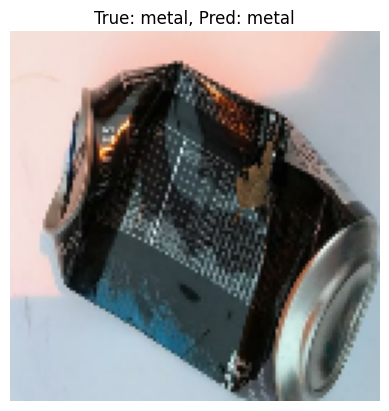

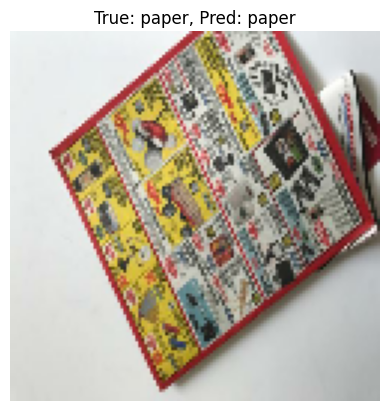

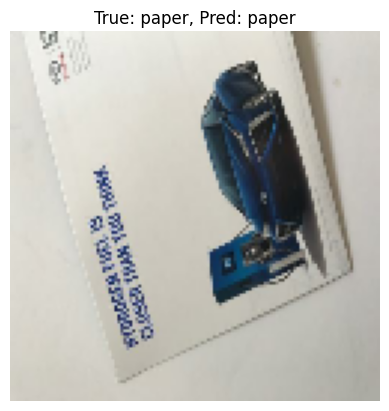

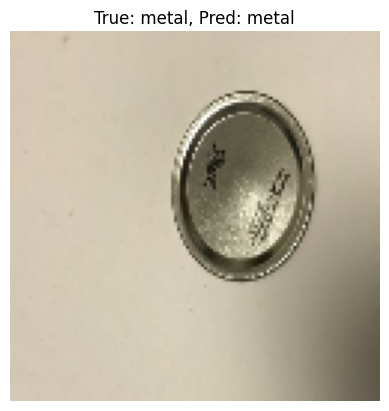

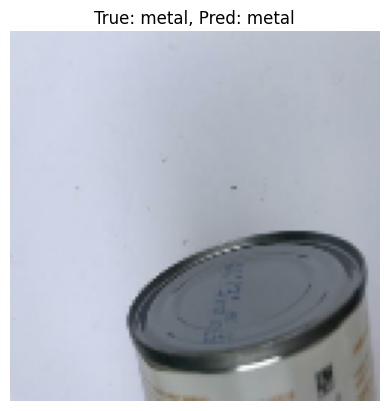

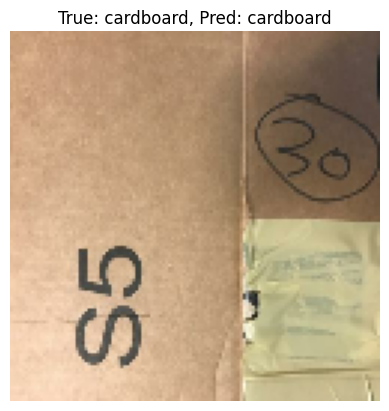

In [27]:
# Extract class names from the training dataset
class_names = train_ds.class_names

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):

    # Generate predictions for the batch of images
    predictions = model.predict(images)

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)

    # Loop through the first 8 images in the batch
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

In [28]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

In [29]:
!pip install gradio

In [30]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [31]:
def classify_image(img):
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((124, 124))

    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)

    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction using the trained model
    prediction = model.predict(img_array)

    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)

    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]

    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]

    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"

In [32]:
iface = gr.Interface(
    fn=classify_image,  # Function to classify image using the trained model
    inputs=gr.Image(type="pil"),  # Accepts input as a PIL image
    outputs="text"  # Outputs prediction as text
)

# Launch the interface
iface.launch()  # Start the Gradio interface for user interaction

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a41a1bd6b5b0053c7b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [33]:
from tensorflow.keras.applications import EfficientNetV2B3

In [34]:
base_model = EfficientNetV2B3(
    include_top=False,
    weights="imagenet",
    input_shape=(124, 124, 3)
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [35]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [36]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early]
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 61s 212ms/step - accuracy: 0.9660 - loss: 0.1270 - val_accuracy: 0.8990 - val_loss: 0.3038
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.9803 - loss: 0.0821 - val_accuracy: 0.9050 - val_loss: 0.2781
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - accuracy: 0.9736 - loss: 0.0938 - val_accuracy: 0.9050 - val_loss: 0.2970
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.9824 - loss: 0.0682 - val_accuracy: 0.9050 - val_loss: 0.2940
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9867 - loss: 0.0611 - val_accuracy: 0.9010 - val_loss: 0.2954


In [37]:
loss, accuracy = model.evaluate(val_ds)
print(f"EfficientNetV2B3 Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9204 - loss: 0.2240
EfficientNetV2B3 Accuracy: 0.9050, Loss: 0.2781


In [38]:
# ----- Test set evaluation -----
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"EfficientNetV2B3 ‒ Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9271 - loss: 0.2125
EfficientNetV2B3 ‒ Test Accuracy: 0.9180, Test Loss: 0.2330


In [39]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true_list, y_pred_list = [], []

# 1️⃣  Iterate ONCE through the (unshuffled) test_ds
for images, labels in test_ds:        # <‑‑ test_ds **without .shuffle()**
    preds = model(images, training=False)
    y_pred_list.append(np.argmax(preds.numpy(), axis=1))

    # If labels are one‑hot, collapse them to class indices
    if labels.ndim == 2:
        labels = tf.argmax(labels, axis=1)
    y_true_list.append(labels.numpy())

# 2️⃣  Stack the results
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# 3️⃣  Now the report matches Keras’ accuracy
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.89      0.89        35
           1       0.98      0.92      0.95        53
           2       0.96      0.96      0.96        48
           3       0.93      0.91      0.92        58
           4       0.90      0.90      0.90        42
           5       0.75      0.90      0.82        20

    accuracy                           0.92       256
   macro avg       0.90      0.91      0.91       256
weighted avg       0.92      0.92      0.92       256



In [40]:
model.save("efficientnetv2b3_model.keras")

In [41]:
from tensorflow.keras.models import load_model

model_b2 = load_model("Effiicientnetv2b2.keras")
model_b3 = load_model("efficientnetv2b3_model.keras")

In [42]:
loss_b2, acc_b2 = model_b2.evaluate(test_ds)
loss_b3, acc_b3 = model_b3.evaluate(test_ds)

print(f"✅ EfficientNetV2B2 Test Accuracy: {acc_b2 * 100:.2f}%")
print(f"✅ EfficientNetV2B3 Test Accuracy: {acc_b3 * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9449 - loss: 0.1941
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9438 - loss: 0.1611
✅ EfficientNetV2B2 Test Accuracy: 91.80%
✅ EfficientNetV2B3 Test Accuracy: 93.36%


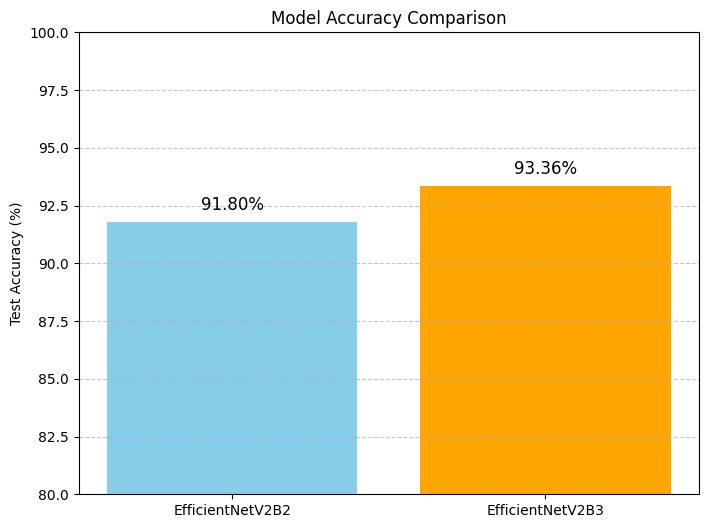

In [43]:
import matplotlib.pyplot as plt

# Model names and their accuracies
models = ['EfficientNetV2B2', 'EfficientNetV2B3']
accuracies = [acc_b2 * 100, acc_b3 * 100]

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['skyblue', 'orange'])

# Add text labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', fontsize=12)

# Chart styling
plt.ylim(80, 100)
plt.ylabel('Test Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [44]:
from sklearn.metrics import classification_report


In [45]:
def evaluate_model(model, model_name, test_ds):
    print(f"\n📋 Classification Report for {model_name}")

    # Extract true labels
    y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

    # Get predictions
    y_pred_probs = model.predict(test_ds)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("🔷 Confusion Matrix:")
    print(cm)

    # Classification Report
    print("\n🔶 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


In [46]:
evaluate_model(model_b2, "EfficientNetV2B2", test_ds_eval)
evaluate_model(model_b3, "EfficientNetV2B3", test_ds_eval)


📋 Classification Report for EfficientNetV2B2
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
🔷 Confusion Matrix:
[[29  0  0  1  0  0]
 [ 0 39  3  0  5  0]
 [ 1  0 47  0  1  1]
 [ 1  0  2 58  0  1]
 [ 0  0  0  0 40  5]
 [ 1  0  1  1  0 19]]

🔶 Classification Report:
              precision    recall  f1-score   support

   cardboard       0.91      0.97      0.94        30
       glass       1.00      0.83      0.91        47
       metal       0.89      0.94      0.91        50
       paper       0.97      0.94      0.95        62
     plastic       0.87      0.89      0.88        45
       trash       0.73      0.86      0.79        22

    accuracy                           0.91       256
   macro avg       0.89      0.90      0.90       256
weighted avg       0.91      0.91      0.91       256


📋 Classification Report for EfficientNetV2B3
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
🔷 Confusion Matrix:
[[29  0  0  1  0  0]
 [ 0 41  2  0  4  0]
 [ 1  0 47  0  1  1]
 [ 1  0  2 58  0  1]
 [ 0  0  0  